In [79]:
# ENV["CONDA_ENV"]="conda_jl"
# ENV["CONDA_JL_HOME"]="$(ENV["HOME"])/.conda/envs/$(ENV["CONDA_ENV"])"
# ENV["PYTHON"]="$(ENV["CONDA_JL_HOME"])/bin/python"

In [2]:
using DrWatson
@quickactivate "TriangularHubbard"
using TriangularHubbard

using PyCall
using PyPlot

using LinearAlgebra
using JSON
using DBInterface
using SQLite
using DataFrames
using DataFramesMeta
using LsqFit
using Printf
using Quadmath
using ProgressMeter
using Dates
mpl = pyimport("matplotlib")
sns = pyimport("seaborn")
sp = pyimport("scipy")
pyimport("scipy.spatial")

backend_pdf = pyimport("matplotlib.backends.backend_pdf")

  Activating project at `/gpfs/research/changlani/Lee_project/TriangularHubbard`


PyObject <module 'matplotlib.backends.backend_pdf' from '/gpfs/home/kyungminlee_42/.conda/envs/conda_jl/lib/python3.9/site-packages/matplotlib/backends/backend_pdf.py'>

In [3]:
PyPlot.rc("axes", labelsize="medium", titlesize="medium")
PyPlot.rc("xtick", labelsize="small")
PyPlot.rc("ytick", labelsize="small")
PyPlot.rc("legend", fontsize="x-small")

cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=true)
markers = ["o", "v", "^", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"]
;

In [4]:
shape_str = "(3,0)x(0,3)"

"(3,0)x(0,3)"

# 1. Read Lattice Data

In [5]:
jsondata = open(datadir("lattice-$shape_str.json"), "r") do f
    JSON.parse(read(f, String))
end

shape = hcat(jsondata["shape"]...)
n_sites = Int(det(shape))
bravaiscoordinates = hcat(jsondata["bravais_coordinates"]...)
reciprocallatticevectors = hcat(jsondata["unitcell"]["reciprocallatticevectors"]...)
sitecoordinates = hcat((x["cartesian_coordinates"] for x in jsondata["supercell"]["sites"])...)
momentums = hcat((x["cartesian_coordinates"] for x in jsondata["momentums"])...)
fractionalmomentums = hcat(([eval(Meta.parse(y)) for y in x["fractional_coordinates"]] for x in jsondata["momentums"])...)
sitegroupmap = Dict()
for (i, vs) in enumerate(jsondata["equivalent_site_pairs"])
    for v in vs
        sitegroupmap[v] = i
    end
end
phases = cis.(-2π * momentums' * sitecoordinates)
n_sitegroup = maximum(values(sitegroupmap))

3

In [6]:
p0 = [4π/3, 0]
R = [cos(π/3) -sin(π/3); sin(π/3) cos(π/3)]
zone_boundary = [p0]
p = p0
for i in 1:5
    p = R * p
    push!(zone_boundary, p)
end
push!(zone_boundary, p0)
zone_boundary = hcat(zone_boundary...);

In [7]:
function getrealspacemap(data::AbstractVector)
    realspacemap = fill(NaN, n_sites)
    @assert length(data) == n_sitegroup
    for i in 1:n_sites
        realspacemap[i] = data[sitegroupmap[[1,i]]]
    end
    return realspacemap
end

getrealspacemap (generic function with 1 method)

In [8]:
realspacemap_test = ones(Float64, (n_sites, 1))
abs2.(phases * realspacemap_test)

9×1 Matrix{Float64}:
 81.0
  4.782469237902384e-30
  1.8797076257219422e-29
  8.874685183736383e-31
  2.0954117794933126e-31
  2.297557386456197e-29
  4.992010415851715e-30
  1.1093356479670479e-29
  1.232595164407831e-30

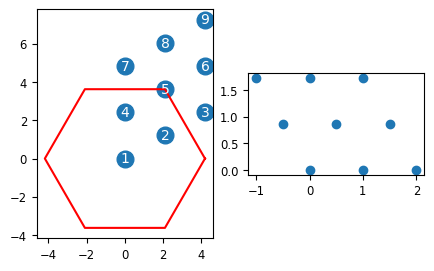

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /gpfs/home/kyungminlee_42/.julia/packages/PyCall/BD546/src/numpy.jl:67


In [9]:
fig = PyPlot.figure(figsize=(5,3))
ax = fig.add_subplot(1,2,1)
ax.plot(2π * momentums[1,:], 2π * momentums[2,:], "o", markersize=12)
for i in 1:size(momentums, 2)
    ax.text(2π * momentums[1,i], 2π * momentums[2,i], "$i", ha="center", va="center", color="w")
end
ax.set_aspect(1.0)
ax.plot(zone_boundary[1,:], zone_boundary[2,:], "r-")


ax = fig.add_subplot(1,2,2)
ax.plot(sitecoordinates[1,:], sitecoordinates[2,:], "o")
ax.set_aspect(1.0)

# 2. Read ED Data

In [10]:
conn = DBInterface.connect(SQLite.DB, datadir("curie", shape_str, "sectors.sqlite3"))
df = DataFrame(DBInterface.execute(conn, """
        SELECT
          sectors.idx, nup, ndn, tii, pii, pic, dim, 
          hopping, interaction, temperature,
          base_energy, partition, energy, energy_squared, correlation, 'dense' as type
        FROM dense_results
        JOIN sectors USING(idx)
        JOIN dense_energy_shifts USING(idx, hopping, interaction)

        UNION

        SELECT
          sectors.idx, nup, ndn, tii, pii, pic, dim, 
          hopping, interaction, temperature,
          base_energy, partition, energy, energy_squared, correlation, 'sparse' as type
        FROM sparse_results
        JOIN sectors USING(idx)
        JOIN sparse_energy_shifts USING(idx, hopping, interaction)
        ;        
    """))
close(conn)

In [11]:
hopping = only(unique(df.hopping))
interaction = only(unique(df.interaction))
;

In [12]:
df[!, :charge] = (df[!, :nup] + df[!, :ndn])
df[!, :charge2] = (df[!, :nup] + df[!, :ndn]).^2
df[!, :Sz] = 0.5 .* (df[!, :nup] - df[!, :ndn])
df[!, :Sz2] = df[!, :Sz].^2
;

In [13]:
println(names(df))

["idx", "nup", "ndn", "tii", "pii", "pic", "dim", "hopping", "interaction", "temperature", "base_energy", "partition", "energy", "energy_squared", "correlation", "type", "charge", "charge2", "Sz", "Sz2"]


In [14]:
rmaps = Dict{String, Vector{Vector{Float64}}}("uu"=> [], "ud" => [], "du" => [], "dd" => [])
for s in df[!, :correlation]
    m = JSON.parse(s)
    replace!(m, nothing=>NaN)
    push!(rmaps["uu"], getrealspacemap(m[1:4:end]))
    push!(rmaps["ud"], getrealspacemap(m[2:4:end]))
    push!(rmaps["du"], getrealspacemap(m[3:4:end]))
    push!(rmaps["dd"], getrealspacemap(m[4:4:end]))
end
rmaps = Dict(k=> hcat(v...) for (k, v) in rmaps)
kmaps = Dict(k => phases * v for (k, v) in rmaps)

Dict{String, Matrix{ComplexF64}} with 4 entries:
  "ud" => [0.0+0.0im 0.0+0.0im … 9.0+0.0im 9.0+0.0im; 0.0+0.0im 0.0+0.0im … -7.…
  "du" => [0.0+0.0im 0.0+0.0im … 9.0+0.0im 9.0+0.0im; 0.0+0.0im 0.0+0.0im … -7.…
  "dd" => [0.0+0.0im 0.0+0.0im … 9.0+0.0im 9.0+0.0im; 0.0+0.0im 0.0+0.0im … -7.…
  "uu" => [0.0+0.0im 0.0+0.0im … 9.0+0.0im 9.0+0.0im; 0.0+0.0im 0.0+0.0im … -7.…

In [15]:
maximum(abs2.(kmaps["ud"] - kmaps["du"]))

0.0

In [16]:
kmaps["SzSz"] = 0.25 * (kmaps["uu"] - kmaps["ud"] - kmaps["du"] + kmaps["dd"])

9×287760 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im

In [17]:
kpoint_indices = Dict("Γ" => 1, "Σ" => 2, "K" => 5)

Dict{String, Int64} with 3 entries:
  "Σ" => 2
  "Γ" => 1
  "K" => 5

In [18]:
for (kname, kindex) in kpoint_indices
    for opname in ["uu", "ud", "du", "dd", "SzSz"]
        df[!, "$(opname)_$(kname)"] = real.(kmaps[opname][kindex,:] .* n_sites);
    end
end

In [19]:
# Comparing two methods of obtaining susceptibility
filter(row -> !isapprox(row.uu_Γ, row.nup.^2 * row.partition), df)

0×35 DataFrame

In [20]:
df[110,:].correlation

"[0.0,0.0,0.0,0.1111111111111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]"

In [21]:
for (irow, row) in enumerate(eachrow(df))
    x = row.uu_Γ
    y = row.nup .* row.nup .* row.partition
    if !isapprox(x, y)
        println("$(irow)\t$(row.idx)\t$(row.temperature)\t$(x)\t$(y)\t$(x - y)")
    end
end

In [22]:
for (irow, row) in enumerate(eachrow(df))
    x = row.dd_Γ
    y = row.ndn .* row.ndn .* row.partition
    if !isapprox(x, y)
        println("$(irow)\t$(row.idx)\t$(row.temperature)\t$(x)\t$(y)\t$(x - y)")
    end
end

In [23]:
for (irow, row) in enumerate(eachrow(df))
    x = row.ud_Γ
    y = row.ndn .* row.nup .* row.partition
    if !isapprox(x, y)
        println("$(irow)\t$(row.idx)\t$(row.temperature)\t$(x)\t$(y)\t$(x - y)")
    end
end

In [24]:
select!(df, Not(:correlation));

In [25]:
temperatures = unique(sort(df.temperature));
charges = unique(sort(df.charge))
# temperatures = temperatures[ temperatures .>= 0.1];

In [26]:
df[!, :Sq] .= eachcol(kmaps["SzSz"]);

### Sector-wise weighting

$$
\langle O \rangle
  = \frac{\sum_{i} e^{-E_i / T} O_{ii}}{\sum_{i} e^{-E_i / T}}
  = \frac{\sum_{i} e^{-E^b_i/T} e^{-(E_i-E^b_i) / T} O_{ii}}{\sum_{i} e^{-E^b_i/T} e^{-(E_i-E^b_i) / T}}
$$

In [27]:
# Comparing two methods of obtaining susceptibility

out = Dict()
for gdf in groupby(df, [:charge, :temperature]; sort=true)
    min_base_energy = minimum(gdf.base_energy)
    q = first(gdf.charge)
    T = first(gdf.temperature)
    boltzmann = exp.(-(gdf.base_energy .- min_base_energy) ./ T)
    susc1 = sum(gdf.Sz2 .* boltzmann .* gdf.partition) / sum(boltzmann .* gdf.partition) / T
    susc2 = sum(gdf.SzSz_Γ .* boltzmann) / sum(boltzmann .* gdf.partition) / T
    if !haskey(out, q)
        out[q] = []
    end
    push!(out[q], [T, susc1, susc2])
end
for q in keys(out)
    out[q] = hcat(out[q]...)
end

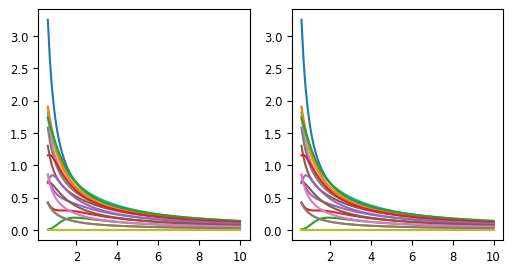

In [28]:
fig = PyPlot.figure(figsize=(6, 3))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
for charge in sort(collect(keys(out)))
    susceptibility = out[charge]
    ax1.plot(susceptibility[1,15:end], susceptibility[2,15:end], label="$charge")
    ax2.plot(susceptibility[1,15:end], susceptibility[3,15:end], label="$charge")
end
# PyPlot.legend()

In [29]:
# Check the differences
for charge in sort(collect(keys(out)))
    susceptibility = out[charge]
    if maximum(abs2.(susceptibility[2, :] - susceptibility[3,:])) > 1E-8
        @show charge
    end
end

In [30]:
# PyPlot.figure(figsize=(3.5, 3))
# for charge in [5, 6,7,8,9,10,11,12, 13]
#     susceptibility = out[charge]
#     PyPlot.plot(susceptibility[1,5:end], 1 ./ susceptibility[2,5:end], label="$charge")
# end
# PyPlot.legend()
# PyPlot.xlim(0, 5)
# PyPlot.ylim(0, 5)

In [31]:
select_charges = charges[0.2 .<= (charges ./ n_sites) .<= 1.8];
select_charge_lookup = Dict(v => k for (k, v) in enumerate(select_charges))
ncols = Int(ceil(sqrt(length(select_charges))))
nrows = Int(ceil(length(select_charges) / ncols))
println(length(select_charges), ", ", nrows, ", ", ncols)

select_temperatures = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
select_temperature_lookup = Dict(v => i for (i, v) in enumerate(select_temperatures))
nrows_T, ncols_T = 3, 3
;

15, 4, 4


# Canonical Ensemble

In [54]:
canonical_df = let
    Qs = Int[]
    Ts = Float64[]
    χ0s = Float64[]
    χΓs = Float64[]
    χΣs = Float64[]
    χKs = Float64[]
    Cvs = Float64[]
    for sdf in groupby(df, [:charge, :temperature])
        Q = first(sdf.charge)
        T = first(sdf.temperature)
        
        E0 = minimum(sdf.base_energy)
        boltzmann = exp.(-(sdf.base_energy .- E0) ./ T)        
        Z = sum(boltzmann .* sdf.partition)
        push!(Qs, Q)
        push!(Ts, T)
        push!(χ0s, sum(sdf.Sz2 .* boltzmann .* sdf.partition) / Z / T)
        push!(χΓs, sum(sdf.SzSz_Γ .* boltzmann) / Z / T)
        push!(χΣs, sum(sdf.SzSz_Σ .* boltzmann) / Z / T)
        push!(χKs, sum(sdf.SzSz_K .* boltzmann) / Z / T)
        let
            corr = sum(
                (sdf.energy_squared
                    + 2 .* sdf.base_energy .* sdf.energy
                    + (sdf.base_energy.^ 2) .* sdf.partition) .* boltzmann    
            ) / Z
            avg = sum((sdf.energy .+ sdf.base_energy .* sdf.partition) .* boltzmann) / Z
            push!(Cvs, (corr - avg^2) / (n_sites * T))
        end
    end
    DataFrame(
        "charge" => Qs,
        "density" => Qs ./ n_sites,
        "temperature" => Ts,
        "specific_heat" => Cvs,
        "susceptibilities_0" => χ0s,
        "susceptibilities_Γ" => χΓs,
        "susceptibilities_Σ" => χΣs,
        "susceptibilities_K" => χKs,
    )
end

sort!(canonical_df, [:charge, :temperature])
;

# Specific Heat

In [77]:
typeof(df)

DataFrame

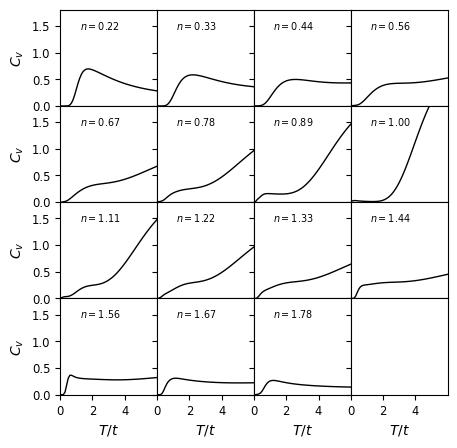

In [55]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, :temperature)
    
    ax.plot(sdf.temperature, sdf.specific_heat, color="k", linewidth=1, linestyle="-")
    ax.axhline(0, linewidth=0.5, color="k")
    ax.axvline(0, linewidth=0.5, color="k")
    ax.text(
        0.2, 0.9, (@sprintf "\$n=%.2f\$" charge/n_sites),
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize="x-small"
    )    
end

for i in 1:nrows
    axs[i, 1].set_ylabel(raw"$C_v$")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
    axs[end, i].set_xticks([0,2,4])
end
axs[1,1].set_xlim(0, 6)
axs[1,1].set_ylim(0, 1.8)

fig.savefig("specific-heat_$(shape_str).pdf", dpi=300, bbox_inches="tight")

In [56]:
# fig = PyPlot.figure(figsize=(5, 5))
# fig.subplots_adjust(hspace=0, wspace=0)

# ax = nothing
# axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
# axs_transpose = permutedims(axs, [2,1])

# for sdf in groupby(canonical_df, :charge)
#     charge = first(sdf.charge)
#     haskey(select_charge_lookup, charge) || continue
#     iq = select_charge_lookup[charge]
#     ax = axs_transpose[iq]
#     sdf = sort(sdf, :temperature)
    
#     ax.plot(sdf.temperature, sdf.specific_heat, color="k", linewidth=1, linestyle="-")
#     ax.axhline(0, linewidth=0.5, color="k")
#     ax.axvline(0, linewidth=0.5, color="k")
#     ax.text(
#         0.1, 0.9, (@sprintf "\$n=%.2f\$" charge/n_sites),
#         transform=ax.transAxes,
#         ha="left", va="top",
#         fontsize="x-small"
#     )
#     ax.axvline(4*hopping/interaction, linestyle="--", color="xkcd:sky blue", linewidth=1)
# end

# for i in 1:nrows
#     axs[i, 1].set_ylabel(raw"$C_v$")
# end
# for i in 1:ncols
#     axs[end, i].set_xlabel(raw"$T/t$")
# end
# # axs[1,1].set_xlim(0, 0.5)
# # axs[1,1].set_xscale("log")
# # axs[1,1].set_ylim(0, 0.2)

# fig.savefig("specific-heat-closeup_$(shape_str).pdf", dpi=300, bbox_inches="tight")

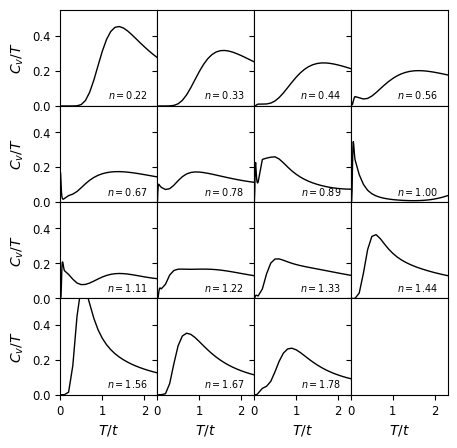

In [64]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

ax = nothing
axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    # density = first(sdf.density)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, order(:temperature))
    
    xs = sdf.temperature
    ys = sdf.specific_heat ./ sdf.temperature
    ax.plot(xs, ys, color="k", linewidth=1, linestyle="-")
    ax.text(
        0.9, 0.05, (@sprintf "\$n=%.2f\$" charge/n_sites),
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize="x-small",
#         bbox=Dict("facecolor"=>"white", "edgecolor"=>"None", "alpha"=>0.5),
    )
#     ax.axvline(1/20, linestyle="--")
end

for i in 1:nrows
    axs[i, 1].set_ylabel(raw"$C_v/T$")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
    axs[end, i].set_xticks([0, 1, 2, ])
end
axs[1,1].set_xlim(0, 2.3)
axs[1,1].set_ylim(0, 0.55)

fig.savefig("entropy_$(shape_str).pdf", dpi=300, bbox_inches="tight")

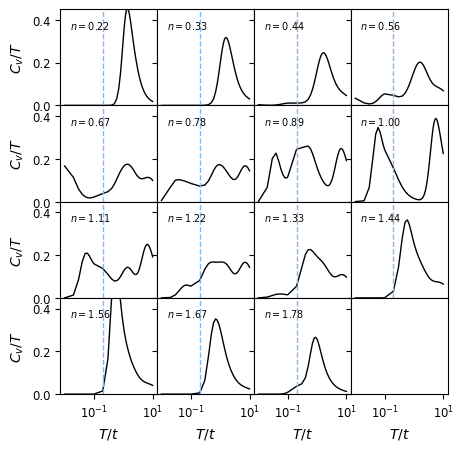

In [65]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

ax = nothing
axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, order(:temperature))
    
    xs = sdf.temperature
    ys = sdf.specific_heat ./ sdf.temperature
    ax.plot(xs, ys, color="k", linewidth=1, linestyle="-")
    ax.text(
        0.1, 0.9, (@sprintf "\$n=%.2f\$" charge/n_sites),
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize="x-small"
    )
    ax.axvline(4*hopping/interaction, linestyle="--", linewidth=1, color="xkcd:sky blue", )
end

for i in 1:nrows
    axs[i, 1].set_ylabel(raw"$C_v/T$")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
    axs[end, i].set_xticks([0,1,])
end
# axs[1,1].set_xlim(0, 0.5)
axs[1,1].set_xscale("log")
axs[1,1].set_ylim(0, 0.45)

fig.savefig("entropy-log-closeup_$(shape_str).pdf", dpi=300, bbox_inches="tight")

# Linear Fits (Curie-Weiss) (χ(Γ))

In [66]:
@. model(x, p) = (x - p[2]) / p[1]

model (generic function with 1 method)

In [75]:
temperature_range = [0.7, 5.5]

canonical_fit_df = let
    charges = Int[]
    intercepts_0, slopes_0 = Float64[], Float64[]
    intercepts_Γ, slopes_Γ = Float64[], Float64[]
    intercepts_K, slopes_K = Float64[], Float64[]
    intercepts_Σ, slopes_Σ = Float64[], Float64[]
    
    for sdf in groupby(canonical_df, :charge)
        any(x -> isinf(x) || isnan(x), 1.0 ./ sdf.susceptibilities_0) && continue
        any(x -> isinf(x) || isnan(x), 1.0 ./ sdf.susceptibilities_Γ) && continue
        any(x -> isinf(x) || isnan(x), 1.0 ./ sdf.susceptibilities_K) && continue
        any(x -> isinf(x) || isnan(x), 1.0 ./ sdf.susceptibilities_Σ) && continue
        
        xs = sdf.temperature
        ys = 1 ./ sdf.susceptibilities_0
        ys = ys[ temperature_range[1] .<= xs .<= temperature_range[2]]
        xs = xs[ temperature_range[1] .<= xs .<= temperature_range[2]]
        f = curve_fit(model, xs, ys, [1.0, 0.0])
        push!(charges, first(sdf.charge))
        push!(intercepts_0, f.param[2])
        push!(slopes_0, f.param[1])
                
        xs = sdf.temperature
        ys = 1 ./ sdf.susceptibilities_Γ
        ys = ys[ temperature_range[1] .<= xs .<= temperature_range[2]]
        xs = xs[ temperature_range[1] .<= xs .<= temperature_range[2]]
        f = curve_fit(model, xs, ys, [1.0, 0.0])
        push!(intercepts_Γ, f.param[2])
        push!(slopes_Γ, f.param[1])

        xs = sdf.temperature
        ys = 1 ./ sdf.susceptibilities_K
        ys = ys[ temperature_range[1] .<= xs .<= temperature_range[2]]
        xs = xs[ temperature_range[1] .<= xs .<= temperature_range[2]]
        f = curve_fit(model, xs, ys, [1.0, 0.0])
        push!(intercepts_K, f.param[2])
        push!(slopes_K, f.param[1])
        
        xs = sdf.temperature
        ys = 1 ./ sdf.susceptibilities_Σ
        ys = ys[ temperature_range[1] .<= xs .<= temperature_range[2]]
        xs = xs[ temperature_range[1] .<= xs .<= temperature_range[2]]
        f = curve_fit(model, xs, ys, [1.0, 0.0])
        push!(intercepts_Σ, f.param[2])
        push!(slopes_Σ, f.param[1])    
    end
    DataFrame(
        "charge" => charges,
        "density" => charges ./ n_sites,
        "intercept_0" => intercepts_0, "slope_0" => slopes_0,
        "intercept_Γ" => intercepts_Γ, "slope_Γ" => slopes_Γ,
        "intercept_Σ" => intercepts_Σ, "slope_Σ" => slopes_Σ,
        "intercept_K" => intercepts_K, "slope_K" => slopes_K,
    )
end


17×10 DataFrame
 Row │ charge  density   intercept_0   slope_0    intercept_Γ   slope_Γ    int ⋯
     │ Int64   Float64   Float64       Float64    Float64       Float64    Flo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │      1  0.111111   7.75972e-17  0.25        7.75972e-17  0.25        7. ⋯
   2 │      2  0.222222  -6.37014e7    6.11125e6  -6.36972e7    6.11084e6   0.
   3 │      3  0.333333  -1.81449      1.01932    -1.81449      1.01932     0.
   4 │      4  0.444444  -0.922259     1.14697    -0.922259     1.14697     0.
   5 │      5  0.555556  -0.580093     1.33181    -0.580093     1.33181     0. ⋯
   6 │      6  0.666667  -0.392491     1.52926    -0.392491     1.52926     0.
   7 │      7  0.777778  -0.319619     1.33895    -0.319619     1.33895    -0.
   8 │      8  0.888889  -0.183169     1.45599    -0.183169     1.45599     0.
   9 │      9  1.0       -0.127731     1.53632    -0.127731     1.53632     0. ⋯
  10 │     10  1.11111    0.138402     1.37299     0.138402     1.37299     0.
  11 │     11  1.22222    0.031668     1.27489     0.031668     1.27489     0.
  12 │     12  1.33333   -0.0653643    1.47362    -0.0653643    1.47362     0.
  13 │     13  1.44444   -0.151404     1.26414    -0.151404     1.26414     0. ⋯
  14 │     14  1.55556   -0.206979     1.03172    -0.206979     1.03172     0.
  15 │     15  1.66667   -0.151397     0.768384   -0.151397     0.768384    0.
  16 │     16  1.77778   -0.0297828    0.500493   -0.0297828    0.500493    0.
  17 │     17  1.88889    7.75972e-17  0.25        2.75724e-16  0.25       -6. ⋯
                                                               4 columns omitted

In [76]:
names(canonical_df)

8-element Vector{String}:
 "charge"
 "density"
 "temperature"
 "specific_heat"
 "susceptibilities_0"
 "susceptibilities_Γ"
 "susceptibilities_Σ"
 "susceptibilities_K"

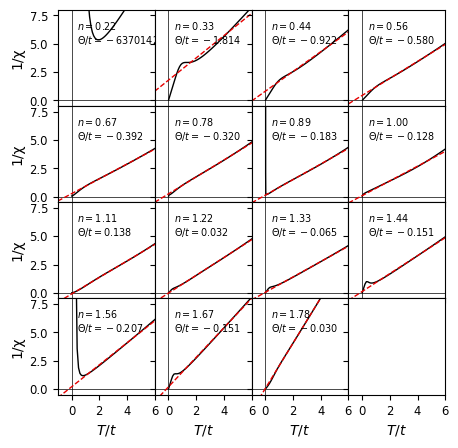

In [70]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

ax = nothing
axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, order(:temperature))
    
    xs = sdf.temperature
    ys = 1.0 ./ sdf.susceptibilities_0
    # @show ax
    # @show xs
    ax.plot(xs, ys, color="k", linewidth=1, linestyle="-")
    ax.axhline(0, linewidth=0.5, color="k")
    ax.axvline(0, linewidth=0.5, color="k")
end

for row in eachrow(fit_df)
    charge = row.charge
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]    
    xs_fit = [-1, 10]
    ys_fit = model(xs_fit, [row.slope_0, row.intercept_0])
    
    ax.plot(xs_fit, ys_fit, linewidth=1, color="xkcd:red", linestyle="--")
    ax.text(
        0.2, 0.9, (@sprintf "\$n=%.2f\$\n\$\\Theta/t=%.3f \$" charge/n_sites row.intercept_0),
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize="x-small"
    )
end

for i in 1:nrows
    axs[i, 1].set_ylabel("1/χ")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
    axs[end, i].set_xticks([0,2,4,6])
end
axs[1,1].set_xlim(-1, 6)
axs[1,1].set_ylim(-0.5, 8)

fig.savefig("curie-weiss_$(shape_str).pdf", dpi=300, bbox_inches="tight")

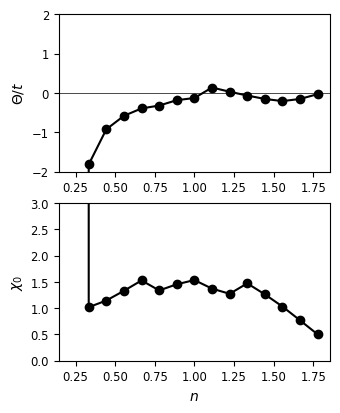

In [71]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> haskey(select_charge_lookup, x.charge), canonical_fit_df)
    ax1.plot(sdf.charge ./ n_sites, sdf.intercept_0, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.charge ./ n_sites, sdf.slope_0, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")
ax1.set_ylim(-2, 2)

ax2.set_ylim(0, 3)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
fig.savefig("curie-weiss-fit_$(shape_str).pdf", dpi=300, bbox_inches="tight")

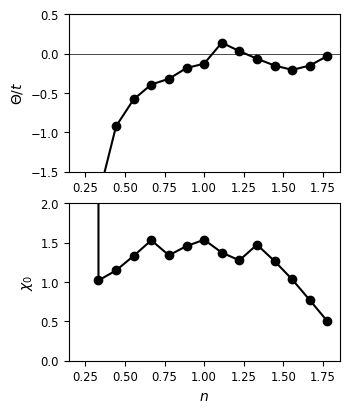

In [74]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> haskey(select_charge_lookup, x.charge), canonical_fit_df)
    ax1.plot(sdf.charge ./ n_sites, sdf.intercept_Γ, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.charge ./ n_sites, sdf.slope_Γ, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")
ax1.set_ylim(-1.5, 0.5)

ax2.set_ylim(0, 2)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
fig.savefig("curie-weiss-fit-GM_$(shape_str).pdf", dpi=300, bbox_inches="tight")

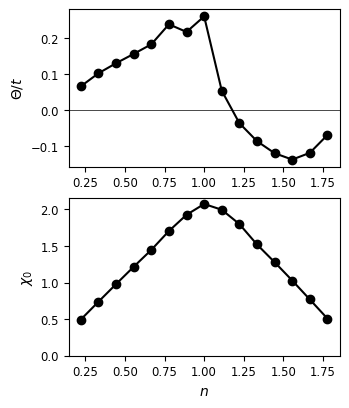

In [74]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> haskey(select_charge_lookup, x.charge), canonical_fit_df)
    ax1.plot(sdf.charge ./ n_sites, sdf.intercept_K, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.charge ./ n_sites, sdf.slope_K, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")

ax2.set_ylim(0, nothing)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
fig.savefig("curie-weiss-fit-K_$(shape_str).pdf", dpi=300, bbox_inches="tight")

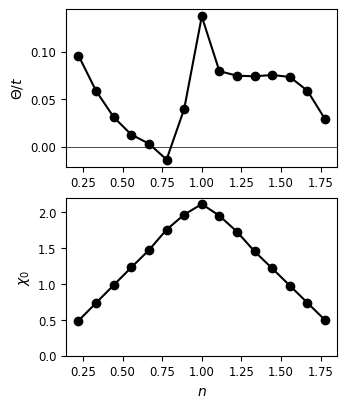

In [75]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> haskey(select_charge_lookup, x.charge), canonical_fit_df)
    ax1.plot(sdf.charge ./ n_sites, sdf.intercept_Σ, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.charge ./ n_sites, sdf.slope_Σ, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")

ax2.set_ylim(0, nothing)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
fig.savefig("curie-weiss-fit-SM_$(shape_str).pdf", dpi=300, bbox_inches="tight")

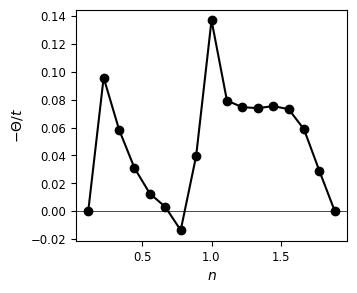

PyObject Text(24.999999999999986, 0.5, '$-\\Theta/t$')

In [52]:
fig = PyPlot.figure(figsize=(3.5, 3))
ax = fig.gca()

let sdf = filter(x -> haskey(select_charge_lookup, x.charge), canonical_fit_df)
    ax.plot(sdf.charge ./ n_sites, sdf.intercept_Σ, marker="o", linestyle="-", color="black")
end
ax.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax.set_xlabel(raw"$n$")
ax.set_ylabel(raw"$-\Theta/t$")
# fig.savefig("weiss-temperature_$(shape_str).pdf", dpi=300, bbox_inches="tight")

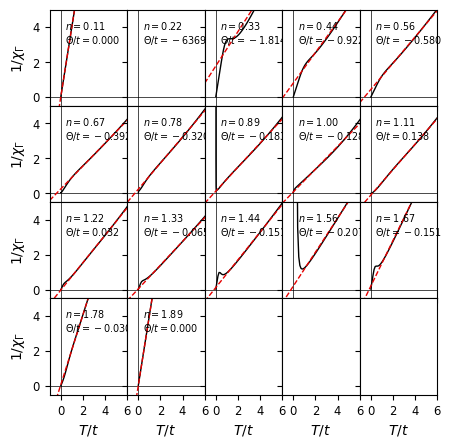

In [53]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

ax = nothing
axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, order(:temperature))
    
    xs = sdf.temperature
    ys = 1.0 ./ sdf.susceptibilities_Γ
    ax.plot(xs, ys, color="k", linewidth=1, linestyle="-")
    ax.axhline(0, linewidth=0.5, color="k")
    ax.axvline(0, linewidth=0.5, color="k")
end

for row in eachrow(canonical_fit_df)
    charge = row.charge
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]    
    xs_fit = [-1, 10]
    ys_fit = model(xs_fit, [row.slope_Γ, row.intercept_Γ])
    
    ax.plot(xs_fit, ys_fit, linewidth=1, color="xkcd:red", linestyle="--")
    ax.text(
        0.2, 0.9, (@sprintf "\$n=%.2f\$\n\$\\Theta/t=%.3f \$" charge/n_sites row.intercept_Γ),
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize="x-small"
    )
end


for i in 1:nrows
    axs[i, 1].set_ylabel(raw"$1/\chi_{\Gamma}$")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
    axs[end, i].set_xticks([0,2,4,6])
end
axs[1,1].set_xlim(-1, 6)
axs[1,1].set_ylim(-0.5, 5)

fig.savefig("susceptibility-GM_$(shape_str).pdf", dpi=300, bbox_inches="tight")

# χ(K)

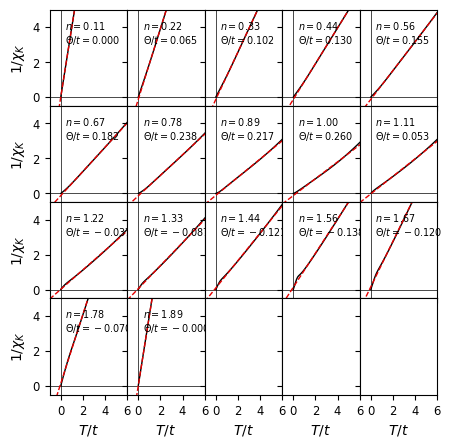

In [54]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

ax = nothing
axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, order(:temperature))
    
    xs = sdf.temperature
    ys = 1.0 ./ sdf.susceptibilities_K
    ax.plot(xs, ys, color="k", linewidth=1, linestyle="-")
    ax.axhline(0, linewidth=0.5, color="k")
    ax.axvline(0, linewidth=0.5, color="k")
end

for row in eachrow(canonical_fit_df)
    charge = row.charge
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]    
    xs_fit = [-1, 10]
    ys_fit = model(xs_fit, [row.slope_K, row.intercept_K])
    
    ax.plot(xs_fit, ys_fit, linewidth=1, color="xkcd:red", linestyle="--")
    ax.text(
        0.2, 0.9, (@sprintf "\$n=%.2f\$\n\$\\Theta/t=%.3f \$" charge/n_sites row.intercept_K),
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize="x-small"
    )
end

for i in 1:nrows
    axs[i, 1].set_ylabel(raw"$1/\chi_{K}$")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
    axs[end, i].set_xticks([0,2,4,6])
end
axs[1,1].set_xlim(-1, 6)
axs[1,1].set_ylim(-0.5, 5)

fig.savefig("susceptibility-K_$(shape_str).pdf", dpi=300, bbox_inches="tight")

# χ(Σ)

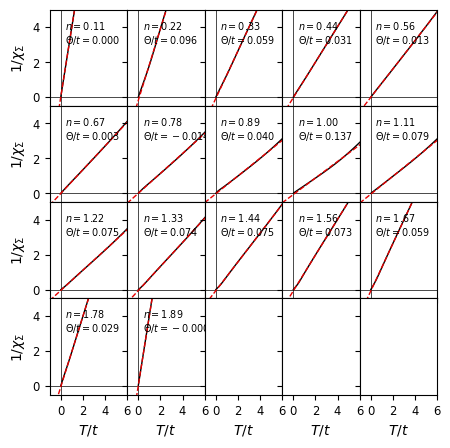

In [55]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

ax = nothing
axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(canonical_df, :charge)
    charge = first(sdf.charge)
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]
    sdf = sort(sdf, order(:temperature))
    
    xs = sdf.temperature
    ys = 1.0 ./ sdf.susceptibilities_Σ
    ax.plot(xs, ys, color="k", linewidth=1, linestyle="-")
    ax.axhline(0, linewidth=0.5, color="k")
    ax.axvline(0, linewidth=0.5, color="k")
end

for row in eachrow(canonical_fit_df)
    charge = row.charge
    haskey(select_charge_lookup, charge) || continue
    iq = select_charge_lookup[charge]
    ax = axs_transpose[iq]    
    xs_fit = [-1, 10]
    ys_fit = model(xs_fit, [row.slope_Σ, row.intercept_Σ])
    
    ax.plot(xs_fit, ys_fit, linewidth=1, color="xkcd:red", linestyle="--")
    ax.text(
        0.2, 0.9, (@sprintf "\$n=%.2f\$\n\$\\Theta/t=%.3f \$" charge/n_sites row.intercept_Σ),
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize="x-small"
    )
end

for i in 1:nrows
    axs[i, 1].set_ylabel(raw"$1/\chi_{\Sigma}$")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
    axs[end, i].set_xticks([0,2,4,6])
end
axs[1,1].set_xlim(-1, 6)
axs[1,1].set_ylim(-0.5, 5)

fig.savefig("susceptibility-SM_$(shape_str).pdf", dpi=300, bbox_inches="tight")

# S(q)

In [56]:
structure_factor_df = let
    Qs = Float64[]
    Ts = Float64[]
    Sqs = Vector{Float64}[]
    
    for sdf in groupby(df, [:charge, :temperature])
        T = first(sdf.temperature)
        Q = first(sdf.charge)
        Sq = zeros(Float64, length(sdf[1, :Sq]))
        Z = 0.0
        for row in eachrow(sdf)
            Sq += row.Sq
            Z += row.partition
        end
        Sq ./= Z
        push!(Qs, Q)
        push!(Ts, T)
        push!(Sqs, real.(Sq))
    end
    DataFrame("charge" => Qs, "temperature" => Ts, "structure_factor" => Sqs)
end
;

In [86]:
k0 = momentums .* 2π
G = reciprocallatticevectors
function plot_Sq(Sq::AbstractVector{<:Real}, ax::PyObject; inverse::Bool=false)
    k = Matrix{Float64}(undef, (2, 0))
    v = Vector{Float64}(undef, 0)
    if inverse
        Sq = -1 ./ Sq
    end
    for R1 in [-1,0,1], R2 in [-1,0,1]
        R = [R1; R2]
        k = hcat(k, broadcast(+, k0, G * R))
        v = vcat(v, Sq)
    end
    if inverse
        minv = minimum(filter(!isnan, v) )
        maxv = maximum(filter(!isnan, v) )
        c = mpl.cm.viridis((v .- minv) ./ (maxv - minv))
    else
        minv = minimum(filter(!isnan, v) )
        maxv = maximum(filter(!isnan, v) )
        c = mpl.cm.viridis(v ./ maxv)
    end
    img = ax.scatter(k[1,:], k[2,:], s=200, c=c, marker="H")
    ax.plot(zone_boundary[1,:], zone_boundary[2,:], color="red")
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xticks([])
    ax.set_yticks([])
    return img
end

plot_Sq (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


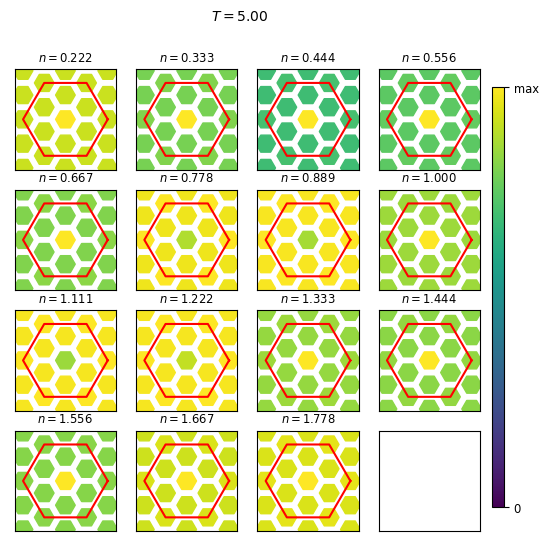

In [87]:
fig = PyPlot.figure(figsize=(6,6))

pdf = backend_pdf.PdfPages("static-structure-factor_$(shape_str).pdf")
@showprogress for T in select_temperatures
    fig.clf()
    axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
    axs_transpose = permutedims(axs, [2,1])
    
    let sdf = filter(x -> x.temperature == T, structure_factor_df)
        img = nothing
        for row in eachrow(sdf)
            charge = row.charge
            haskey(select_charge_lookup, charge) || continue            
            iq = select_charge_lookup[charge]
            Sq = copy(row.structure_factor)
            ax = axs_transpose[iq]
            img = plot_Sq(Sq, ax)
            ax.set_title((@sprintf "\$n=%.3f\$" charge/n_sites), fontsize="small")
        end
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cbar = fig.colorbar(img, cax=cbar_ax, ticks=[0,1])
        cbar_ax.set_yticklabels(["0", "max"])        
    end
    fig.suptitle((@sprintf "\$T=%.2f\$" T), fontsize="medium")
    pdf.savefig(fig, dpi=300, bbox_inches="tight")
end
let d = pdf.infodict()
    d["Title"] = "Static Structure Factor"
    d["Author"] = "Kyungmin Lee <kyungmin.lee.42@gmail.com>"
    d["Subject"] = "Shape = $shape_str"
    d["CreationDate"] = string(today())
end
pdf.close()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


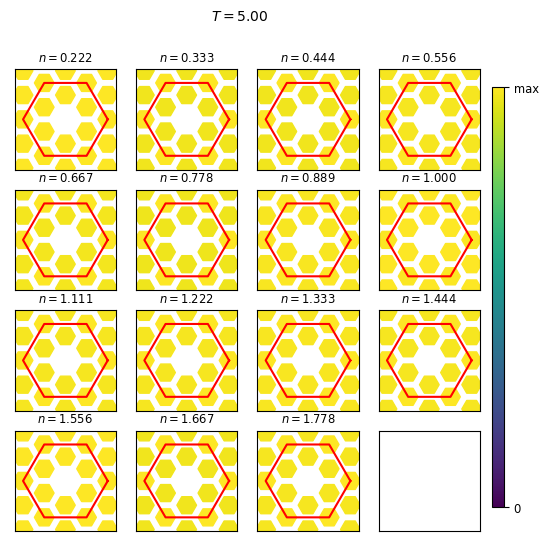

In [88]:
k0 = momentums .* 2π
G = reciprocallatticevectors

fig = PyPlot.figure(figsize=(6,6))

pdf = backend_pdf.PdfPages("static-structure-factor-no-GM_$(shape_str).pdf")
@showprogress for T in select_temperatures
    fig.clf()
    axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
    axs_transpose = permutedims(axs, [2,1])
    
    let sdf = filter(x -> x.temperature == T, structure_factor_df)
        img = nothing
        for row in eachrow(sdf)
            charge = row.charge
            haskey(select_charge_lookup, charge) || continue            
            iq = select_charge_lookup[charge]
            ax = axs_transpose[iq]
            Sq = copy(row.structure_factor)
            Sq[1] = NaN
            img = plot_Sq(Sq, ax)
            ax.set_title((@sprintf "\$n=%.3f\$" charge/n_sites), fontsize="small")
        end
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cbar = fig.colorbar(img, cax=cbar_ax, ticks=[0,1])
        cbar_ax.set_yticklabels(["0", "max"])        
    end
    fig.suptitle((@sprintf "\$T=%.2f\$" T), fontsize="medium")
    pdf.savefig(fig, dpi=300, bbox_inches="tight")
end
let d = pdf.infodict()
    d["Title"] = "Static Structure Factor"
    d["Author"] = "Kyungmin Lee <kyungmin.lee.42@gmail.com>"
    d["Subject"] = "shape: $shape_str"
    d["CreationDate"] = string(today())
end
pdf.close()

## S(q) Charge per page

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


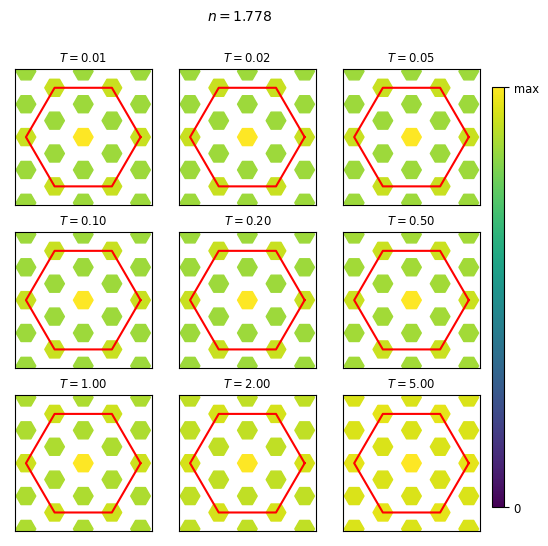

In [89]:
fig = PyPlot.figure(figsize=(6,6))
pdf = backend_pdf.PdfPages("static-structure-factor-charge-per-page_$(shape_str).pdf")
@showprogress for charge in select_charges
    fig.clf()
    axs = fig.subplots(nrows_T, ncols_T, sharex=true, sharey=true)
    axs_transpose = permutedims(axs, [2,1])
    let sdf = filter(x -> x.charge == charge, structure_factor_df)
        img = nothing
        for row in eachrow(sdf)
            temperature = row.temperature
            haskey(select_temperature_lookup, temperature) || continue
            iT = select_temperature_lookup[temperature]
            ax = axs_transpose[iT]
            Sq = copy(row.structure_factor)
            img = plot_Sq(Sq, ax)
            ax.set_title((@sprintf "\$T=%.2f\$" temperature), fontsize="small")
        end
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cbar = fig.colorbar(img, cax=cbar_ax, ticks=[0,1])
        cbar_ax.set_yticklabels(["0", "max"])        
    end
    fig.suptitle((@sprintf "\$n=%.3f\$" charge/n_sites), fontsize="medium")
    pdf.savefig(fig, dpi=300, bbox_inches="tight")
end
let d = pdf.infodict()
    d["Title"] = "Static Structure Factor"
    d["Author"] = "Kyungmin Lee <kyungmin.lee.42@gmail.com>"
    d["Subject"] = "shape: $shape_str"
    d["CreationDate"] = string(today())
end
pdf.close()

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


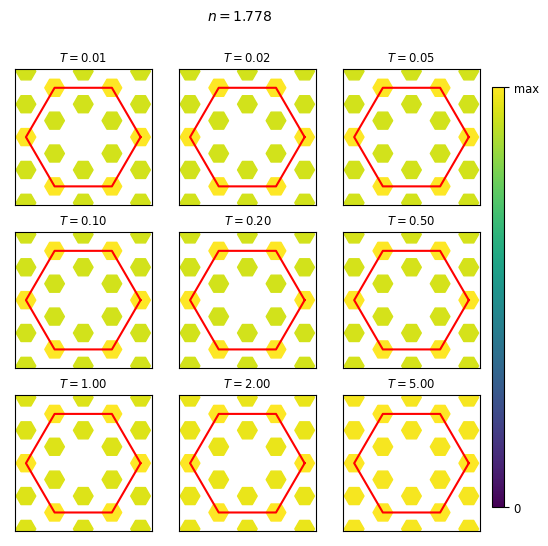

In [90]:
fig = PyPlot.figure(figsize=(6,6))
pdf = backend_pdf.PdfPages("static-structure-factor-no-GM-charge-per-page_$(shape_str).pdf")
@showprogress for charge in select_charges
    fig.clf()
    axs = fig.subplots(nrows_T, ncols_T, sharex=true, sharey=true)
    axs_transpose = permutedims(axs, [2,1])
    let sdf = filter(x -> x.charge == charge, structure_factor_df)
        img = nothing
        for row in eachrow(sdf)
            temperature = row.temperature
            haskey(select_temperature_lookup, temperature) || continue
            iT = select_temperature_lookup[temperature]
            ax = axs_transpose[iT]
            Sq = copy(row.structure_factor)
            Sq[1] = NaN
            img = plot_Sq(Sq, ax)
            ax.set_title((@sprintf "\$T=%.2f\$" temperature), fontsize="small")
        end
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cbar = fig.colorbar(img, cax=cbar_ax, ticks=[0,1])
        cbar_ax.set_yticklabels(["0", "max"])        
    end
    fig.suptitle((@sprintf "\$n=%.3f\$" charge/n_sites), fontsize="medium")
    pdf.savefig(fig, dpi=300, bbox_inches="tight")
end
let d = pdf.infodict()
    d["Title"] = "Static Structure Factor"
    d["Author"] = "Kyungmin Lee <kyungmin.lee.42@gmail.com>"
    d["Subject"] = "shape: $shape_str"
    d["CreationDate"] = string(today())
end
pdf.close()

# Grand Canonical

In [91]:
@. model(x, p) = (x - p[2]) / p[1]

model (generic function with 1 method)

In [92]:
grand_canonical_df = let
    chemical_potential_list = -10:0.1:25
    chemical_potentials = Float64[]
    temperatures = Float64[]
    densities = Float64[]
    χ0s = Float64[]
    χΓs = Float64[]
    χΣs = Float64[]
    χKs = Float64[]
    Cvs = Float64[]

    for sdf in groupby(df, :temperature)
        for μ in chemical_potential_list
            T = first(sdf.temperature)
            E0 = minimum(sdf.base_energy .- μ .* sdf.charge)
            boltzmann = exp.(-(sdf.base_energy .- μ .* sdf.charge .- E0 ) ./ T)
            
            Z = sum(boltzmann .* sdf.partition)
            push!(chemical_potentials, μ)
            push!(temperatures, T)
            push!(densities, sum(sdf.charge .* boltzmann .* sdf.partition) / sum(boltzmann .* sdf.partition) / n_sites)
            
            push!(χ0s, sum(sdf.Sz2 .* boltzmann .* sdf.partition) / Z / T)
            push!(χΓs, sum(sdf.SzSz_Γ .* boltzmann) / Z / T)
            push!(χΣs, sum(sdf.SzSz_Σ .* boltzmann) / Z / T)
            push!(χKs, sum(sdf.SzSz_K .* boltzmann) / Z / T)
            let
                corr = sum(
                    (sdf.energy_squared
                        + 2 .* sdf.base_energy .* sdf.energy
                        + (sdf.base_energy.^ 2) .* sdf.partition) .* boltzmann    
                ) / Z
                avg = sum((sdf.energy .+ sdf.base_energy .* sdf.partition) .* boltzmann) / Z
                push!(Cvs, (corr - avg^2) / (n_sites * T))
            end
            
            
        end
    end
    DataFrame(
        "chemical_potential" => chemical_potentials,
        "temperature" => temperatures,
        "density" => densities,
        
        "specific_heat" => Cvs,
        "susceptibilities_0" => χ0s,
        "susceptibilities_Γ" => χΓs,
        "susceptibilities_Σ" => χΣs,
        "susceptibilities_K" => χKs,        
    )
end
sort!(grand_canonical_df, [:chemical_potential, :temperature])
;


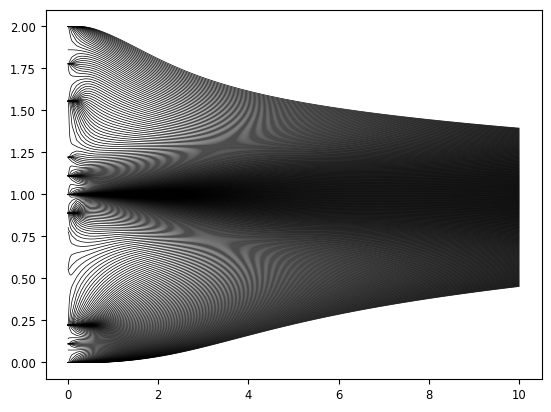

In [93]:
for sdf in groupby(grand_canonical_df, :chemical_potential)
    PyPlot.plot(sdf.temperature, sdf.density, "k-", linewidth=0.5)
end

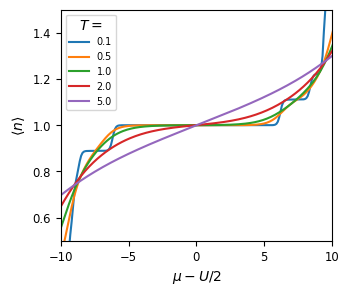

In [94]:
fig = PyPlot.figure(figsize=(3.5, 3))
ax = fig.gca()
for sdf in groupby(grand_canonical_df, :temperature)
    T = first(sdf.temperature)
    T ∈ [0.1, 0.5, 1.0, 2.0, 5.0] || continue
    ax.plot(sdf.chemical_potential .- interaction / 2, sdf.density, alpha=1, label= (@sprintf "%.1f" T)    )
end
ax.set_xlim(-20, 15)
ax.set_ylim(0, 2.1)

ax.set_xlim(-10,10)
ax.set_ylim(0.5, 1.5)

ax.legend(title="\$T=\$", fontsize="x-small")
ax.set_xlabel(raw"$\mu - U/2$")
ax.set_ylabel(raw"$\langle n \rangle$")
fig.savefig("density-vs-chemical-potential_$shape_str.pdf", dpi=300, bbox_inches="tight")

In [98]:
target_densities = 0.2:0.05:1.8

grand_canonical_df = let
    ρs = Float64[]
    converged_ρs = Float64[]
    μs = Float64[]
    Ts = Float64[]
    χ0s = Float64[]
    χΓs = Float64[]
    χΣs = Float64[]
    χKs = Float64[]
    Cvs = Float64[]

    for sdf in groupby(df, :temperature)
        T = first(sdf.temperature)    
        for ρ in target_densities
            μ = NaN
            for trial in 1:10
                function f!(F, x)
                    μ = x[1]
                    E0 = minimum(sdf.base_energy .- μ .* sdf.charge)
                    boltzmann = exp.(-(sdf.base_energy .- μ .* sdf.charge .- E0 ) ./ T)
                    Z = sum(boltzmann .* sdf.partition)
                    F[1] = sum(sdf.charge .* boltzmann .* sdf.partition) / Z / n_sites - ρ
                end
                y = nlsolve(f!, [5*rand()]; autodiff=:forward, iterations=20000)
                μ = y.zero[1]
                if converged(y)
                    break
                end
            end

            T = first(sdf.temperature)
            E0 = minimum(sdf.base_energy .- μ .* sdf.charge)
            boltzmann = exp.(-(sdf.base_energy .- μ .* sdf.charge .- E0 ) ./ T)

            Z = sum(boltzmann .* sdf.partition)
            
            push!(ρs, ρ)
            push!(Ts, T)
            push!(μs, μ)
            push!(converged_ρs, sum(sdf.charge .* boltzmann .* sdf.partition) / sum(boltzmann .* sdf.partition) / n_sites)
            push!(χ0s, sum(sdf.Sz2 .* boltzmann .* sdf.partition) / Z / T)
            push!(χΓs, sum(sdf.SzSz_Γ .* boltzmann) / Z / T)
            push!(χΣs, sum(sdf.SzSz_Σ .* boltzmann) / Z / T)
            push!(χKs, sum(sdf.SzSz_K .* boltzmann) / Z / T)
            let
                corr = sum(
                    (sdf.energy_squared
                        + 2 .* sdf.base_energy .* sdf.energy
                        + (sdf.base_energy.^ 2) .* sdf.partition) .* boltzmann    
                ) / Z
                avg = sum((sdf.energy .+ sdf.base_energy .* sdf.partition) .* boltzmann) / Z
                push!(Cvs, (corr - avg^2) / (n_sites * T))
            end
        end
    end
    DataFrame(
        "density" => ρs,
        "converged_density" => converged_ρs,
        "chemical_potential" => μs,
        "temperature" => Ts,
        "specific_heat" => Cvs,
        "susceptibilities_0" => χ0s,
        "susceptibilities_Γ" => χΓs,
        "susceptibilities_Σ" => χΣs,
        "susceptibilities_K" => χKs,
    )
end

3597×9 DataFrame
  Row │ density  converged_density  chemical_potential  temperature  specific_ ⋯
      │ Float64  Float64            Float64             Float64      Float64   ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │    0.2                0.2            -5.0764           0.01      46.18 ⋯
    2 │    0.25               0.25            0.621731         0.01       1.07
    3 │    0.3                0.3             0.634368         0.01       2.46
    4 │    0.35               0.35            0.641803         0.01       3.35
    5 │    0.4                0.4             0.647908         0.01       3.68 ⋯
    6 │    0.45               0.45            0.654028         0.01       3.30
    7 │    0.5                0.5             0.661948         0.01       2.13
    8 │    0.55               0.55            0.685825         0.01       0.23
    9 │    0.6                0.6             0.918815         0.01       3.52 ⋯
   10 │    0.65               0.65            0.927931         0.01       5.64
   11 │    0.7                0.7             0.935536         0.01       5.22
  ⋮   │    ⋮             ⋮                  ⋮                ⋮             ⋮   ⋱
 3588 │    1.35               1.35           23.5504          10.0       10.28
 3589 │    1.4                1.4            25.1604          10.0       10.81 ⋯
 3590 │    1.45               1.45           26.7608          10.0       11.07
 3591 │    1.5                1.5            28.3891          10.0       11.05
 3592 │    1.55               1.55           30.0828          10.0       10.77
 3593 │    1.6                1.6            31.8811          10.0       10.28 ⋯
 3594 │    1.65               1.65           33.8265          10.0        9.61
 3595 │    1.7                1.7            35.9708          10.0        8.79
 3596 │    1.75               1.75           38.3871          10.0        7.81
 3597 │    1.8                1.8            41.1972          10.0        6.67 ⋯
                                                 5 columns and 3576 rows omitted

In [106]:
filter!(row -> row.temperature >= 0.05, grand_canonical_df);

In [107]:
grand_canonical_df

3465×9 DataFrame
  Row │ density  converged_density  chemical_potential  temperature  specific_ ⋯
      │ Float64  Float64            Float64             Float64      Float64   ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │    0.2                0.2            -4.99322          0.05       9.23 ⋯
    2 │    0.25               0.25            0.470404         0.05       0.22
    3 │    0.3                0.3             0.531438         0.05       0.51
    4 │    0.35               0.35            0.567555         0.05       0.68
    5 │    0.4                0.4             0.598179         0.05       0.72 ⋯
    6 │    0.45               0.45            0.629837         0.05       0.63
    7 │    0.5                0.5             0.670974         0.05       0.42
    8 │    0.55               0.55            0.760118         0.05       0.18
    9 │    0.6                0.6             0.874392         0.05       0.68 ⋯
   10 │    0.65               0.65            0.924664         0.05       1.02
   11 │    0.7                0.7             0.967615         0.05       0.95
  ⋮   │    ⋮             ⋮                  ⋮                ⋮             ⋮   ⋱
 3456 │    1.35               1.35           23.5504          10.0       10.28
 3457 │    1.4                1.4            25.1604          10.0       10.81 ⋯
 3458 │    1.45               1.45           26.7608          10.0       11.07
 3459 │    1.5                1.5            28.3891          10.0       11.05
 3460 │    1.55               1.55           30.0828          10.0       10.77
 3461 │    1.6                1.6            31.8811          10.0       10.28 ⋯
 3462 │    1.65               1.65           33.8265          10.0        9.61
 3463 │    1.7                1.7            35.9708          10.0        8.79
 3464 │    1.75               1.75           38.3871          10.0        7.81
 3465 │    1.8                1.8            41.1972          10.0        6.67 ⋯
                                                 5 columns and 3444 rows omitted

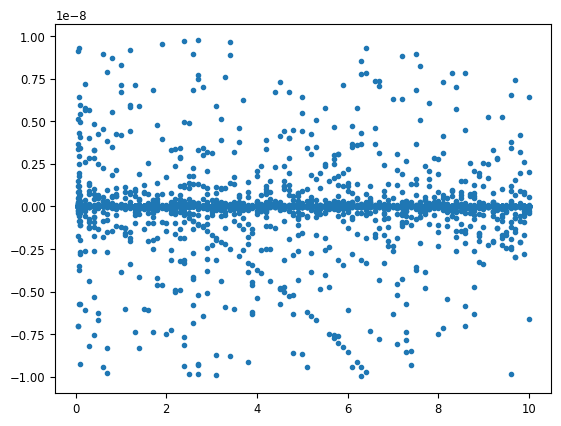

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1528cc5284c0>

In [108]:
PyPlot.plot(grand_canonical_df.temperature, grand_canonical_df.density - grand_canonical_df.converged_density, ".")

In [109]:
filter(row -> !isapprox(row.density, row.converged_density; atol=1E-4, rtol=1E-4), grand_canonical_df)

0×9 DataFrame

In [110]:
temperature_range = [0.7, 5.5]

grand_canonical_fit_df = let
    densities = Float64[]
    intercepts_0, slopes_0 = Float64[], Float64[]
    intercepts_Γ, slopes_Γ = Float64[], Float64[]
    intercepts_K, slopes_K = Float64[], Float64[]
    intercepts_Σ, slopes_Σ = Float64[], Float64[]
    
    for sdf in groupby(grand_canonical_df, :density)
        any(x -> isinf(x) || isnan(x), 1.0 ./ sdf.susceptibilities_0) && continue
        any(x -> isinf(x) || isnan(x), 1.0 ./ sdf.susceptibilities_Γ) && continue
        any(x -> isinf(x) || isnan(x), 1.0 ./ sdf.susceptibilities_K) && continue
        any(x -> isinf(x) || isnan(x), 1.0 ./ sdf.susceptibilities_Σ) && continue
        
        push!(densities, first(sdf.density))
                
        xs = sdf.temperature
        ys = 1 ./ sdf.susceptibilities_0
        ys = ys[ temperature_range[1] .<= xs .<= temperature_range[2]]
        xs = xs[ temperature_range[1] .<= xs .<= temperature_range[2]]
        f = curve_fit(model, xs, ys, [1.0, 0.0])
        push!(intercepts_0, f.param[2])
        push!(slopes_0, f.param[1])
                
        xs = sdf.temperature
        ys = 1 ./ sdf.susceptibilities_Γ
        ys = ys[ temperature_range[1] .<= xs .<= temperature_range[2]]
        xs = xs[ temperature_range[1] .<= xs .<= temperature_range[2]]
        f = curve_fit(model, xs, ys, [1.0, 0.0])
        push!(intercepts_Γ, f.param[2])
        push!(slopes_Γ, f.param[1])

        xs = sdf.temperature
        ys = 1 ./ sdf.susceptibilities_K
        ys = ys[ temperature_range[1] .<= xs .<= temperature_range[2]]
        xs = xs[ temperature_range[1] .<= xs .<= temperature_range[2]]
        f = curve_fit(model, xs, ys, [1.0, 0.0])
        push!(intercepts_K, f.param[2])
        push!(slopes_K, f.param[1])
        
        xs = sdf.temperature
        ys = 1 ./ sdf.susceptibilities_Σ
        ys = ys[ temperature_range[1] .<= xs .<= temperature_range[2]]
        xs = xs[ temperature_range[1] .<= xs .<= temperature_range[2]]
        f = curve_fit(model, xs, ys, [1.0, 0.0])
        push!(intercepts_Σ, f.param[2])
        push!(slopes_Σ, f.param[1])    
    end
    DataFrame("density" => densities,
        "intercept_0" => intercepts_0, "slope_0" => slopes_0,
        "intercept_Γ" => intercepts_Γ, "slope_Γ" => slopes_Γ,
        "intercept_Σ" => intercepts_Σ, "slope_Σ" => slopes_Σ,
        "intercept_K" => intercepts_K, "slope_K" => slopes_K,
    )
end


33×9 DataFrame
 Row │ density  intercept_0  slope_0   intercept_Γ  slope_Γ   intercept_Σ  slo ⋯
     │ Float64  Float64      Float64   Float64      Float64   Float64      Flo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    0.2   -3.42428     0.793515  -3.42428     0.793515    0.0737006  0.4 ⋯
   2 │    0.25  -3.68879     1.01917   -3.68879     1.01917     0.0715713  0.5
   3 │    0.3   -1.96692     0.942415  -1.96692     0.942415    0.0611466  0.6
   4 │    0.35  -1.34885     0.978996  -1.34885     0.978996    0.0497153  0.7
   5 │    0.4   -1.01225     1.03928   -1.01225     1.03928     0.0390098  0.8 ⋯
   6 │    0.45  -0.795783    1.105     -0.795783    1.105       0.0296442  0.9
   7 │    0.5   -0.645665    1.16952   -0.645665    1.16952     0.0219743  1.1
   8 │    0.55  -0.537625    1.22946   -0.537625    1.22946     0.0163124  1.2
   9 │    0.6   -0.458128    1.28283   -0.458128    1.28283     0.0130187  1.3 ⋯
  10 │    0.65  -0.398421    1.32849   -0.398421    1.32849     0.0126088  1.4
  11 │    0.7   -0.351989    1.36603   -0.351989    1.36603     0.015928   1.5
  ⋮  │    ⋮          ⋮          ⋮           ⋮          ⋮           ⋮           ⋱
  24 │    1.35  -0.0139919   1.25991   -0.0139919   1.25991     0.0797157  1.4
  25 │    1.4   -0.0385576   1.21041   -0.0385576   1.21041     0.0768857  1.3 ⋯
  26 │    1.45  -0.0651003   1.14943   -0.0651003   1.14943     0.0748349  1.2
  27 │    1.5   -0.0913789   1.07669   -0.0913789   1.07669     0.0730126  1.0
  28 │    1.55  -0.113124    0.992191  -0.113124    0.992191    0.070817   0.9
  29 │    1.6   -0.125117    0.896622  -0.125117    0.896622    0.0676447  0.8 ⋯
  30 │    1.65  -0.123956    0.791888  -0.123956    0.791888    0.0630147  0.7
  31 │    1.7   -0.110362    0.680984  -0.110362    0.680984    0.0566872  0.6
  32 │    1.75  -0.088759    0.567078  -0.088759    0.567078    0.048735   0.5
  33 │    1.8   -0.0647956   0.452534  -0.0647956   0.452534    0.0395493  0.4 ⋯
                                                   3 columns and 12 rows omitted

In [165]:
select_target_densities = 0.3:0.1:1.7
select_target_density_lookup = Dict(ρ=>i for (i, ρ) in enumerate(select_target_densities))

Dict{Float64, Int64} with 15 entries:
  1.3 => 11
  1.2 => 10
  0.3 => 1
  1.4 => 12
  1.7 => 15
  0.5 => 3
  1.5 => 13
  1.0 => 8
  0.7 => 5
  0.4 => 2
  1.1 => 9
  0.9 => 7
  1.6 => 14
  0.8 => 6
  0.6 => 4

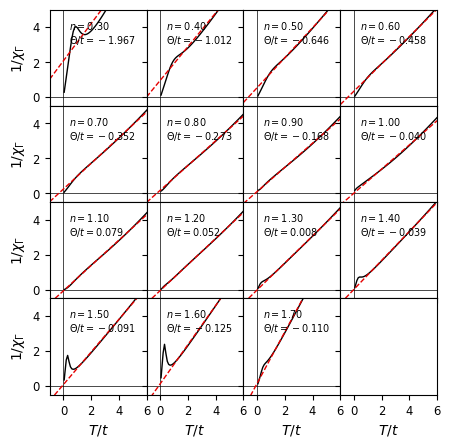

In [167]:
fig = PyPlot.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

ax = nothing
axs = fig.subplots(nrows, ncols, sharex=true, sharey=true)
axs_transpose = permutedims(axs, [2,1])

for sdf in groupby(grand_canonical_df, :density)
    density = first(sdf.density)
    haskey(select_target_density_lookup, density) || continue
    iq = select_target_density_lookup[density]
    ax = axs_transpose[iq]
    sdf = sort(sdf, :temperature)
    
    xs = sdf.temperature
    ys = 1.0 ./ sdf.susceptibilities_Γ
    ax.plot(xs, ys, color="k", linewidth=1, linestyle="-")
    ax.axhline(0, linewidth=0.5, color="k")
    ax.axvline(0, linewidth=0.5, color="k")
end

for row in eachrow(grand_canonical_fit_df)
    density = row.density
    haskey(select_target_density_lookup, density) || continue
    iq = select_target_density_lookup[density]
    ax = axs_transpose[iq]    
    xs_fit = [-1, 10]
    ys_fit = model(xs_fit, [row.slope_Γ, row.intercept_Γ])

    ax.plot(xs_fit, ys_fit, linewidth=1, color="xkcd:red", linestyle="--")
    ax.text(
        0.2, 0.9, (@sprintf "\$n=%.2f\$\n\$\\Theta/t=%.3f \$" density row.intercept_Γ),
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize="x-small"
    )
end

for i in 1:nrows
    axs[i, 1].set_ylabel(raw"$1/\chi_{\Gamma}$")
end
for i in 1:ncols
    axs[end, i].set_xlabel(raw"$T/t$")
    axs[end, i].set_xticks([0,2,4,6])
end
axs[1,1].set_xlim(-1, 6)
axs[1,1].set_ylim(-0.5, 5)

fig.savefig("gce-susceptibility-GM_$(shape_str).pdf", dpi=300, bbox_inches="tight")

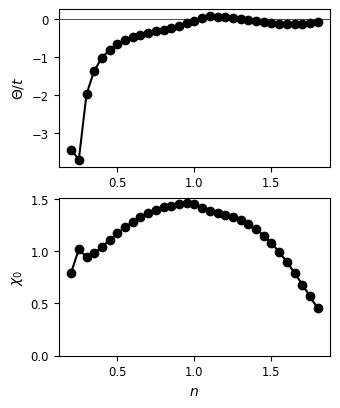

In [122]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> 0.2 <= x.density <= 1.8, grand_canonical_fit_df)
    ax1.plot(sdf.density, sdf.intercept_0, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.density, sdf.slope_0, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")

ax2.set_ylim(0, nothing)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
fig.savefig("gce-curie-weiss-fit_$(shape_str).pdf", dpi=300, bbox_inches="tight")

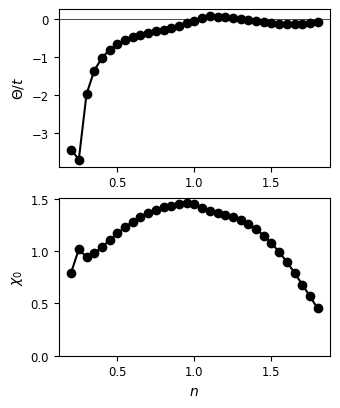

In [123]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> 0.2 <= x.density <= 1.8, grand_canonical_fit_df)
    ax1.plot(sdf.density, sdf.intercept_Γ, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.density, sdf.slope_Γ, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")

ax2.set_ylim(0, nothing)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
fig.savefig("gce-curie-weiss-fit_$(shape_str).pdf", dpi=300, bbox_inches="tight")



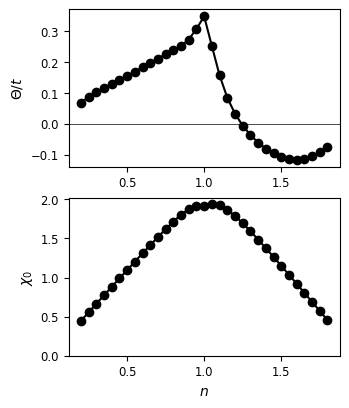

In [124]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> 0.2 <= x.density <= 1.8, grand_canonical_fit_df)
    ax1.plot(sdf.density, sdf.intercept_K, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.density, sdf.slope_K, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")

ax2.set_ylim(0, nothing)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
fig.savefig("gce-curie-weiss-fit_$(shape_str).pdf", dpi=300, bbox_inches="tight")

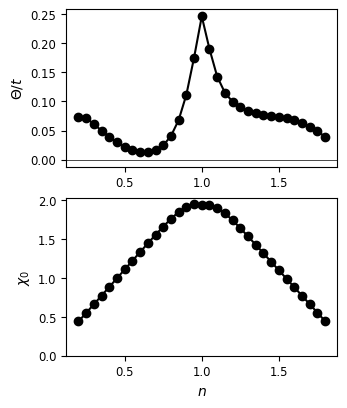

In [125]:
fig = PyPlot.figure(figsize=(3.5, 4.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)
let sdf = filter(x -> 0.2 <= x.density <= 1.8, grand_canonical_fit_df)
    ax1.plot(sdf.density, sdf.intercept_Σ, marker="o", linestyle="-", color="black")
    ax2.plot(sdf.density, sdf.slope_Σ, marker="o", linestyle="-", color="black")
end
ax1.axhline(0, color="black", linewidth=0.5, linestyle="-")
ax1.set_ylabel(raw"$\Theta/t$")

ax2.set_ylim(0, nothing)
ax2.set_ylabel(raw"$\chi_0$")
ax2.set_xlabel(raw"$n$")
fig.savefig("gce-curie-weiss-fit_$(shape_str).pdf", dpi=300, bbox_inches="tight")

# ----------- Cut Here -----------------

In [49]:
# results = []
# for T in temperatures
#     idx = df[!, :temperature] .== T
#     Z = sum(df[idx, :partition])
#     ks = [sum(df[idx, :partition] .* kmaps[i, idx]) / Z for i in 1:n_sites]
#     push!(results, (T => ks))
# end

In [50]:
# kmap_T_dependence = [hcat([[T, real(V[i])] for (T, V) in results]...) for i in 1:size(momentums,2)]

In [51]:
# for i in [1,2,5]
#     Ts = kmap_T_dependence[i][1,:]
#     Sqs = kmap_T_dependence[i][2,:]
#     χs = Sqs ./ Ts
#     PyPlot.plot(Ts, 1.0 ./ χs, "-", label="$i")
# end
# PyPlot.legend()
# PyPlot.ylim()

In [52]:
# k1 = hcat([[T, V[1]] for (T, V) in results]...)

In [53]:
# select_temperatures = [0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0];

In [54]:
# select_indices = [findfirst(==(y), temperatures) for y in select_temperatures]

In [131]:
# fig = PyPlot.figure(figsize=(3.5, 7))
# maxval = 0.0
# ax = nothing
# img = nothing


# for i in 1:8
#     j = select_indices[i]
#     T, Sq = results[j]
#     ax = fig.add_subplot(4,2,i)
#     k0 = momentums .* 2π
#     G = reciprocallatticevectors
#     v0 = abs2.(Sq)
#     k = Matrix{Float64}(undef, (2,0))
#     v = Vector{Float64}(undef, 0)
#     for R1 in [-1,0,1], R2 in [-1,0,1]
#         R = [R1;R2]
#         k = hcat(k, broadcast(+, k0, G * R))
#         v = vcat(v, v0)
#     end
#     img = ax.scatter(k[1,:], k[2,:], s=300, c=mpl.cm.viridis(v ./ maximum(v)), marker="H")
#     ax.plot(zone_boundary[1,:], zone_boundary[2,:], color="red")
#     ax.set_xlim(-5,5)
#     ax.set_ylim(-5,5)
#     ax.set_aspect(1.0)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_title("T=$(T)")
# end
# cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
# cbar = fig.colorbar(img, cax=cbar_ax, ticks=[0,1])
# # cbar_ax.set_yticks([0, 1])
# cbar_ax.set_yticklabels(["0", "max"])

In [197]:
cubicreciprocallattice = hcat(([R1, R2]  for R1 in -3:3 for R2 in -3:3)...)
index_gamma = only(i for (i, c) in enumerate(eachcol(cubicreciprocallattice)) if c == [0,0])
reciprocallattice = reciprocallatticevectors * cubicreciprocallattice

2×49 Matrix{Float64}:
 -18.8496  -18.8496  -18.8496  …  18.8496  18.8496  18.8496  18.8496
 -32.6484  -25.3932  -18.138      10.8828  18.138   25.3932  32.6484

25

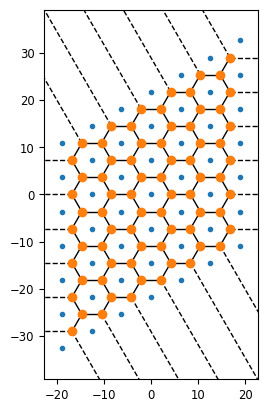

In [199]:
voro = sp.spatial.Voronoi(reciprocallattice')

sp.spatial.voronoi_plot_2d(voro)
ax = PyPlot.gca()
# ax.plot([0,4π/3], [0,0])
ax.set_aspect(1.0)

In [194]:
# p0 = [4π/3, 0]
# R = [cos(π/3) -sin(π/3); sin(π/3) cos(π/3)]
# zone_boundary = [p0]
# p = p0
# for i in 1:5
#     p = R * p
#     push!(zone_boundary, p)
# end
# push!(zone_boundary, p0)
# zone_boundary = hcat(zone_boundary...)

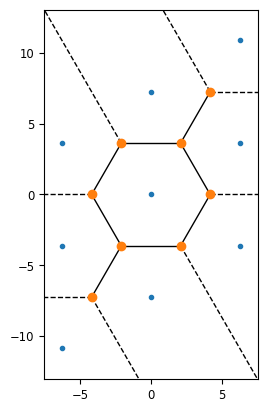

In [177]:
voro.points

9×2 Matrix{Float64}:
 -6.28319  -10.8828
 -6.28319   -3.6276
 -6.28319    3.6276
  0.0       -7.2552
  0.0        0.0
  0.0        7.2552
  6.28319   -3.6276
  6.28319    3.6276
  6.28319   10.8828